# Bias Adjustment for CMIP6 Models


Use Empirical Quantile Mapping and Principle Component Analysis to adjust the precipitation biases in CMIP6 models

##### References

David Huard et al. (n.d.). 08 - Getting and bias-correcting CMIP6 climate data. https://ravenpy.readthedocs.io/en/latest/notebooks/08_Getting_and_bias_correcting_CMIP6_data.html 

xclim. Statistical Downscaling and Bias-Adjustment. https://xclim.readthedocs.io/en/stable/notebooks/sdba.html


## Imports

In [1]:
from __future__ import annotations

import datetime as dt
import intake
from intake import open_catalog
import fsspec
from pathlib import Path 
import cftime  # noqa
import matplotlib.pyplot as plt
import nc_time_axis  # noqa
import numpy as np
import xarray as xr
import xclim
from xclim import sdba

%matplotlib inline

### Define a start and end date

In [2]:
reference_start_day = dt.datetime(1950, 1, 1)
reference_end_day = dt.datetime(2011, 1, 1)
# Notice we are using one day before and one day after the desired period
# This is to account for any UTC shifts that might require getting data in a previous or later time.


### Functions

In [3]:
# Function to load data
def load_data(dataframe):
    # get the path to a specific zarr store (the first one from the dataframe above)
    zstore = dataframe.zstore.values[-1]
    print(zstore)

    # create a mutable-mapping-style interface to the store
    mapper = fsspec.get_mapper(zstore)

    # open it using xarray and zarr
    ds = xr.open_zarr(mapper, consolidated=True)
    # Re-grid longtitude to [-180, 180]
    #ds_180 = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')
    
    return ds

def convert_units(ds):
    # Convert precipitation units from kg m-2 s-1 to mm yr-1
    ds = ds * (86400*365)
    ds_yr = ds.assign_attrs(units="mm year-1")

    return ds_yr
    

### Import and Load Data

In [4]:
# Import dataset
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cmipdf = col.df

In [5]:
#Get dataframes 
canesm5_pr = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'pr' & experiment_id == 'historical' & source_id == 'CanESM5'")
cmcc_pr = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'pr' & experiment_id == 'historical' & source_id == 'CMCC-CM2-SR5'")
gfdl_pr = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'pr' & experiment_id == 'historical' & source_id == 'GFDL-ESM4'")
had_pr = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'pr' & experiment_id == 'historical' & source_id == 'HadGEM3-GC31-LL'")
nor_pr = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'pr' & experiment_id == 'historical' & source_id == 'NorESM2-MM'")


In [6]:
out_folder = Path.home() / "Documents/jupyter/data"
# Load and convert dataframe to dataset
can_hist =  load_data(canesm5_pr)
cmcc_hist = load_data(cmcc_pr)
gfdl_hist = load_data(gfdl_pr)
had_hist = load_data(had_pr)
nor_hist = load_data(nor_pr)

gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical/r6i1p2f1/Amon/pr/gn/v20190429/
gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/historical/r2i1p2f1/Amon/pr/gn/v20211109/
gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Amon/pr/gr1/v20190726/
gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/historical/r5i1p1f3/Amon/pr/gn/v20210315/
gs://cmip6/CMIP6/CMIP/NCC/NorESM2-MM/historical/r3i1p1f1/Amon/pr/gn/v20200702/


## Prepare Model Data for Quantile Mapping

### HadGEM3-GC31-LL / Reference Model

In [7]:
# Code used from David Huard, Ravenpy Notebook, "Getting and bias-correcting CMIP6 climate data."

# Convert to numpy.datetime64 object for compatibility.
had = had_hist.convert_calendar("standard", align_on="date")

# Extract only the dates that we really want.
# Again, this is done via lazy loading, and is not actually using memory at this point.
had = had.sel(time=slice(reference_start_day, reference_end_day))

# Set the date to the midnight of the given day.
had = had.assign_coords(time=had.time.dt.floor("D"))

# Rechunk the data so it is much faster to read (single chunk rather than 1 chunk per day)
historical_pr = had['pr'].chunk(-1) # had to remove numpy line above for this to run

#display(historical_pr)

### CanESM5

In [8]:
# Code used from David Huard, Ravenpy Notebook, "Getting and bias-correcting CMIP6 climate data."

# Convert to numpy.datetime64 object for compatibility.
can = can_hist.convert_calendar("standard", align_on="date")

# Extract only the dates that we really want.
# Again, this is done via lazy loading, and is not actually using memory at this point.
can = can.sel(time=slice(reference_start_day, reference_end_day))

# Set the date to the midnight of the given day.
can = can.assign_coords(time=can.time.dt.floor("D"))

# Rechunk the data so it is much faster to read (single chunk rather than 1 chunk per day)
can_hist_pr = can['pr'].chunk(-1)

#display(can_hist_pr)

### CMCC-CM2-SR5

In [9]:
# Code used from David Huard, Ravenpy Notebook, "Getting and bias-correcting CMIP6 climate data."

# Convert to numpy.datetime64 object for compatibility.
cmcc = cmcc_hist.convert_calendar("standard", align_on="date")

# Extract only the dates that we really want.
# Again, this is done via lazy loading, and is not actually using memory at this point.
cmcc = cmcc.sel(time=slice(reference_start_day, reference_end_day))

# Set the date to the midnight of the given day.
cmcc = cmcc.assign_coords(time=cmcc.time.dt.floor("D"))

# Rechunk the data so it is much faster to read (single chunk rather than 1 chunk per day)
cmcc_hist_pr = cmcc['pr'].chunk(-1)

#display(cmcc_hist_pr)

### GFDL-ESM4

In [10]:
# Code used from David Huard, Ravenpy Notebook, "Getting and bias-correcting CMIP6 climate data."

# Convert to numpy.datetime64 object for compatibility.
gfdl = gfdl_hist.convert_calendar("standard", align_on="date")

# Extract only the dates that we really want.
# Again, this is done via lazy loading, and is not actually using memory at this point.
gfdl = gfdl.sel(time=slice(reference_start_day, reference_end_day))

# Set the date to the midnight of the given day.
gfdl = gfdl.assign_coords(time=gfdl.time.dt.floor("D"))

# Rechunk the data so it is much faster to read (single chunk rather than 1 chunk per day)
gfdl_hist_pr = gfdl['pr'].chunk(-1)

#display(gfdl_hist_pr)

### NorESM2-MM

In [11]:
# Code used from David Huard, Ravenpy Notebook, "Getting and bias-correcting CMIP6 climate data."

# Convert to numpy.datetime64 object for compatibility.
nor = nor_hist.convert_calendar("standard", align_on="date")

# Extract only the dates that we really want.
# Again, this is done via lazy loading, and is not actually using memory at this point.
nor = nor.sel(time=slice(reference_start_day, reference_end_day))

# Set the date to the midnight of the given day.
nor = nor.assign_coords(time=nor.time.dt.floor("D"))

# Rechunk the data so it is much faster to read (single chunk rather than 1 chunk per day)
nor_hist_pr = nor['pr'].chunk(-1) # had to remove numpy line above for this to run

#display(nor_hist_pr)

Convert the units of the precipitation data

In [12]:
can_hist_pr = convert_units(can_hist_pr)
cmcc_hist_pr = convert_units(cmcc_hist_pr)
gfdl_hist_pr = convert_units(gfdl_hist_pr)
had_hist_pr = convert_units(historical_pr)
nor_hist_pr = convert_units(nor_hist_pr)

Train adjustment function 

In [13]:
# Code used from David Huard, Ravenpy Notebook, "Getting and bias-correcting CMIP6 climate data."

# Use xclim utilities (SDBA) to give information on the type of window used for the bias correction.
group_month_window = sdba.utils.Grouper("time.dayofyear", window=15)

# This is an adjusting function. It builds the tool that will perform the corrections.
Adjustment = sdba.DetrendedQuantileMapping.train(
    ref=had_hist_pr, hist=can_hist_pr, nquantiles=50, kind="+", group=group_month_window
)

# Apply the correction factors on the reference period.
corrected_ref_precip = Adjustment.adjust(had_hist_pr, interp="linear")

# Ensure that the precipitation is non-negative, which can happen with some climate models.
corrected_ref_precip = corrected_ref_precip.where(corrected_ref_precip > 0, 0)


*Note for the cell above:*

Precipitation needs to be above zero as there cannot be negative amounts of precipitation. This can be accounted for using the method above (the `where` function) or by using a multiplicative adjustment function.

## Empirical Quantile Mapping and Principle Components

In [14]:
had_ref_pr = had_hist_pr.sel(lat=slice(0,55), lon = slice(225, 310))
had_ref_pr = had_ref_pr.where(had_ref_pr > 0, 0)

nor_pr = nor_hist_pr.sel(lat=slice(0,55), lon = slice(225, 310))
nor_pr = nor_pr.where(nor_pr > 0, 0)

can_pr = can_hist_pr.sel(lat=slice(0,55), lon = slice(225, 310))
can_pr = can_pr.where(can_pr > 0, 0)

cmcc_pr = cmcc_hist_pr.sel(lat=slice(0,55), lon = slice(225, 310))
cmcc_pr = cmcc_pr.where(cmcc_pr > 0, 0)

gfdl_pr = gfdl_hist_pr.sel(lat=slice(0,55), lon = slice(225, 310))
gfdl_pr = gfdl_pr.where(gfdl_pr > 0, 0)

### GFDL Adjustment

In [15]:
# Code based on xclim's notebook, "Statistical Downscaling and Bias-Adjustment"

reft = had_ref_pr.isel(lat=15, lon=[0,44]).drop_vars(["lon", "lat"])
simt = gfdl_pr.isel(lat=15, lon=[0, 67]).drop_vars(["lon", "lat"])

# Principal Components Adj, no grouping and use "lon" as the space dimensions
PCA = sdba.PrincipalComponents.train(reft, simt, group="time", crd_dim="lon")
scen1 = PCA.adjust(simt)

# QM, no grouping, 20 quantiles and additive adjustment
EQM = sdba.EmpiricalQuantileMapping.train(
    reft, scen1, group="time", nquantiles=50, kind="+"
)
scen2 = EQM.adjust(scen1)
scen2 = scen2.where(scen2 > 0, 0) # remove any values below 0

Text(0.5, 1.0, 'Components')

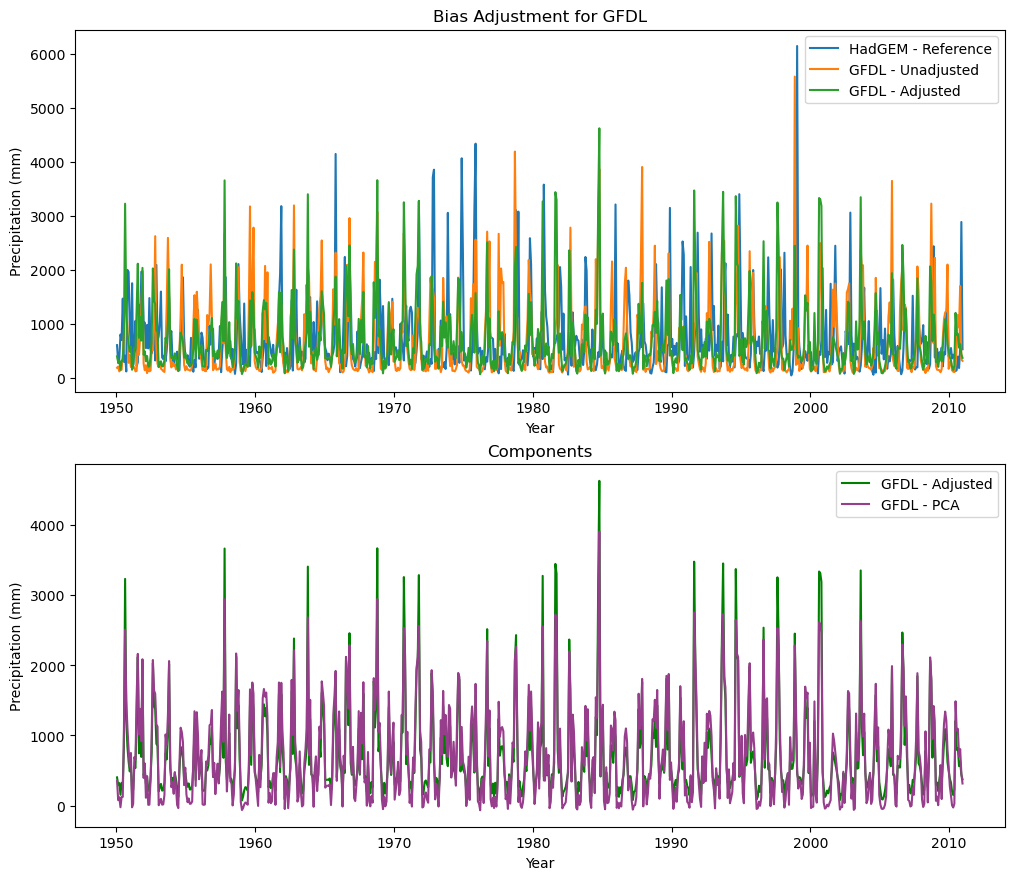

In [16]:
# Code based on xclim's notebook, "Statistical Downscaling and Bias-Adjustment"

# some Analysis figures
fig = plt.figure(figsize=(12, 16))
gs = plt.matplotlib.gridspec.GridSpec(3, 2, fig)


axT = plt.subplot(gs[0, :])
reft.isel(lon=1).plot(ax=axT, label="HadGEM - Reference")
simt.isel(lon=1).plot(ax=axT, label="GFDL - Unadjusted")
scen2.isel(lon=1).plot(ax=axT, label="GFDL - Adjusted")
axT.set_ylabel("Precipitation (mm)")
axT.set_xlabel("Year")
axT.legend()
axT.set_title("Bias Adjustment for GFDL")

#PCA and EQM Plots
axT = plt.subplot(gs[1,:])
scen2.isel(lon=1).plot(ax=axT, label="GFDL - Adjusted", color='green')
scen1.isel(lon=1).plot(ax=axT, label="GFDL - PCA", color='#963e8b')
axT.set_ylabel("Precipitation (mm)")
axT.set_xlabel("Year")
axT.legend()
axT.set_title("Components")

### CMCC Adjustment

In [17]:
# Code based on xclim's notebook, "Statistical Downscaling and Bias-Adjustment"

reft = had_ref_pr.isel(lat=15, lon=[0,44]).drop_vars(["lon", "lat"])
simt = cmcc_pr.isel(lat=15, lon=[0, 68]).drop_vars(["lon", "lat"])

# Principal Components Adj, no grouping and use "lon" as the space dimensions
PCA = sdba.PrincipalComponents.train(reft, simt, group="time", crd_dim="lon")
scen1 = PCA.adjust(simt)

# QM, no grouping, 20 quantiles and additive adjustment
EQM = sdba.EmpiricalQuantileMapping.train(
    reft, scen1, group="time", nquantiles=50, kind="+"
)
scen2 = EQM.adjust(scen1)
scen2 = scen2.where(scen2 > 0, 0) # remove any values below 0

Text(0.5, 1.0, 'Components')

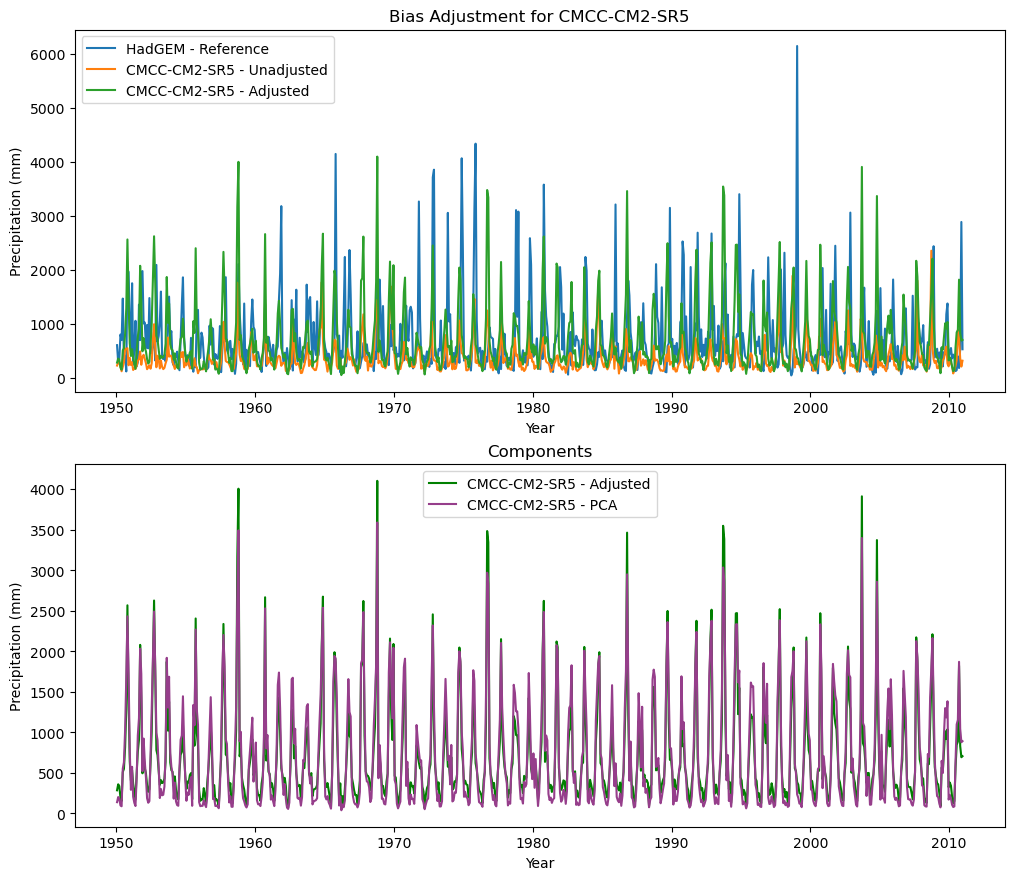

In [18]:
# Code based on xclim's notebook, "Statistical Downscaling and Bias-Adjustment"

# some Analysis figures
fig = plt.figure(figsize=(12, 16))
gs = plt.matplotlib.gridspec.GridSpec(3, 2, fig)


axT = plt.subplot(gs[0, :])
reft.isel(lon=1).plot(ax=axT, label="HadGEM - Reference")
simt.isel(lon=1).plot(ax=axT, label="CMCC-CM2-SR5 - Unadjusted")
scen2.isel(lon=1).plot(ax=axT, label="CMCC-CM2-SR5 - Adjusted")
axT.set_ylabel("Precipitation (mm)")
axT.set_xlabel("Year")
axT.legend()
axT.set_title("Bias Adjustment for CMCC-CM2-SR5")

#PCA and EQM Plots
axT = plt.subplot(gs[1,:])
scen2.isel(lon=1).plot(ax=axT, label="CMCC-CM2-SR5 - Adjusted", color='green')
scen1.isel(lon=1).plot(ax=axT, label="CMCC-CM2-SR5 - PCA", color='#963e8b')
axT.set_ylabel("Precipitation (mm)")
axT.set_xlabel("Year")
axT.legend()
axT.set_title("Components")

### CanESM5 Adjustment

In [19]:
# Code based on xclim's notebook, "Statistical Downscaling and Bias-Adjustment"

reft = had_ref_pr.isel(lat=15, lon=[0,44]).drop_vars(["lon", "lat"])
simt = can_pr.isel(lat=15, lon=[0, 30]).drop_vars(["lon", "lat"])

# Principal Components Adj, no grouping and use "lon" as the space dimensions
PCA = sdba.PrincipalComponents.train(reft, simt, group="time", crd_dim="lon")
scen1 = PCA.adjust(simt)

# QM, no grouping, 20 quantiles and additive adjustment
EQM = sdba.EmpiricalQuantileMapping.train(
    reft, scen1, group="time", nquantiles=50, kind="+"
)
scen2 = EQM.adjust(scen1)
scen2 = scen2.where(scen2 > 0, 0) # remove any values below 0

Text(0.5, 1.0, 'Components')

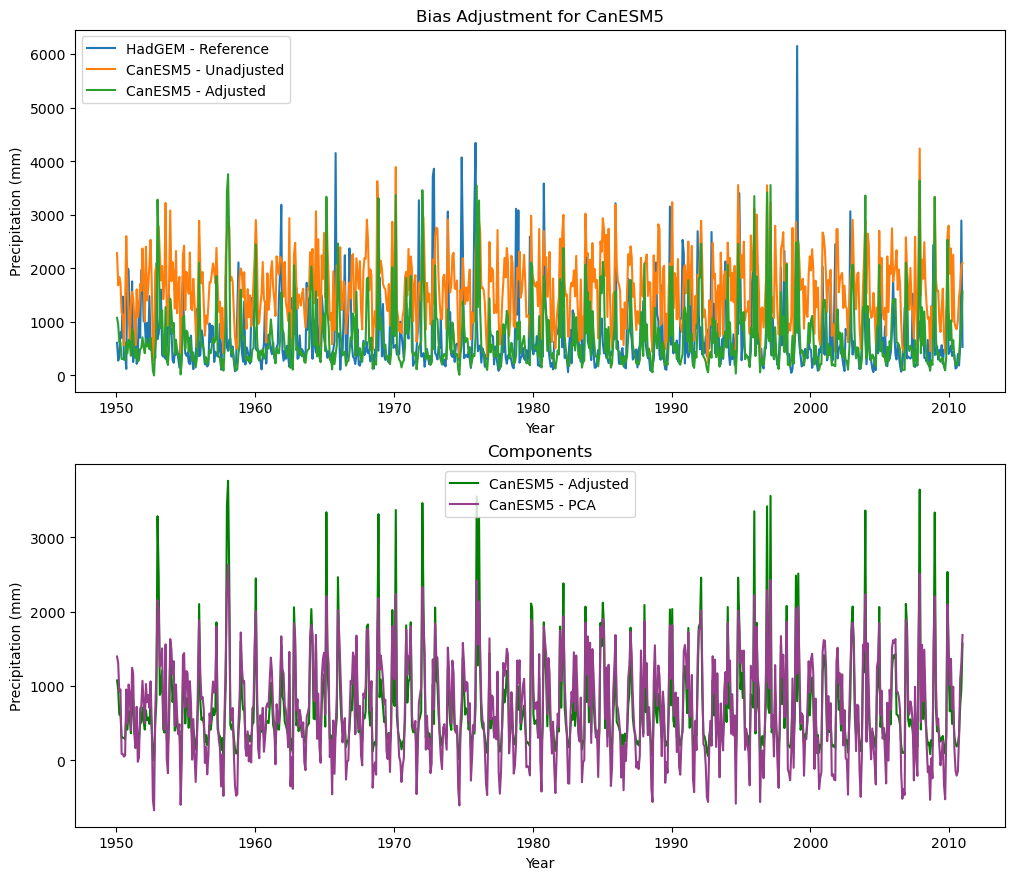

In [20]:
# Code based on xclim's notebook, "Statistical Downscaling and Bias-Adjustment"

# some Analysis figures
fig = plt.figure(figsize=(12, 16))
gs = plt.matplotlib.gridspec.GridSpec(3, 2, fig)


axT = plt.subplot(gs[0, :])
reft.isel(lon=1).plot(ax=axT, label="HadGEM - Reference")
simt.isel(lon=1).plot(ax=axT, label="CanESM5 - Unadjusted")
scen2.isel(lon=1).plot(ax=axT, label="CanESM5 - Adjusted")
axT.set_ylabel("Precipitation (mm)")
axT.set_xlabel("Year")
axT.legend()
axT.set_title("Bias Adjustment for CanESM5")

#PCA and EQM Plots
axT = plt.subplot(gs[1,:])
scen2.isel(lon=1).plot(ax=axT, label="CanESM5 - Adjusted", color='green')
scen1.isel(lon=1).plot(ax=axT, label="CanESM5 - PCA", color='#963e8b')
axT.set_ylabel("Precipitation (mm)")
axT.set_xlabel("Year")
axT.legend()
axT.set_title("Components")

### NorESM2 Adjustment

In [21]:
# Code based on xclim's notebook, "Statistical Downscaling and Bias-Adjustment"

reft = had_ref_pr.isel(lat=15, lon=[0,44]).drop_vars(["lon", "lat"])
simt = nor_pr.isel(lat=15, lon=[0, 68]).drop_vars(["lon", "lat"])

# Principal Components Adj, no grouping and use "lon" as the space dimensions
PCA = sdba.PrincipalComponents.train(reft, simt, group="time", crd_dim="lon")
scen1 = PCA.adjust(simt)

# QM, no grouping, 20 quantiles and additive adjustment
EQM = sdba.EmpiricalQuantileMapping.train(
    reft, scen1, group="time", nquantiles=50, kind="+"
)
scen2 = EQM.adjust(scen1)

scen2 = scen2.where(scen2 > 0, 0) # remove any values below 0

Text(0.5, 1.0, 'Components')

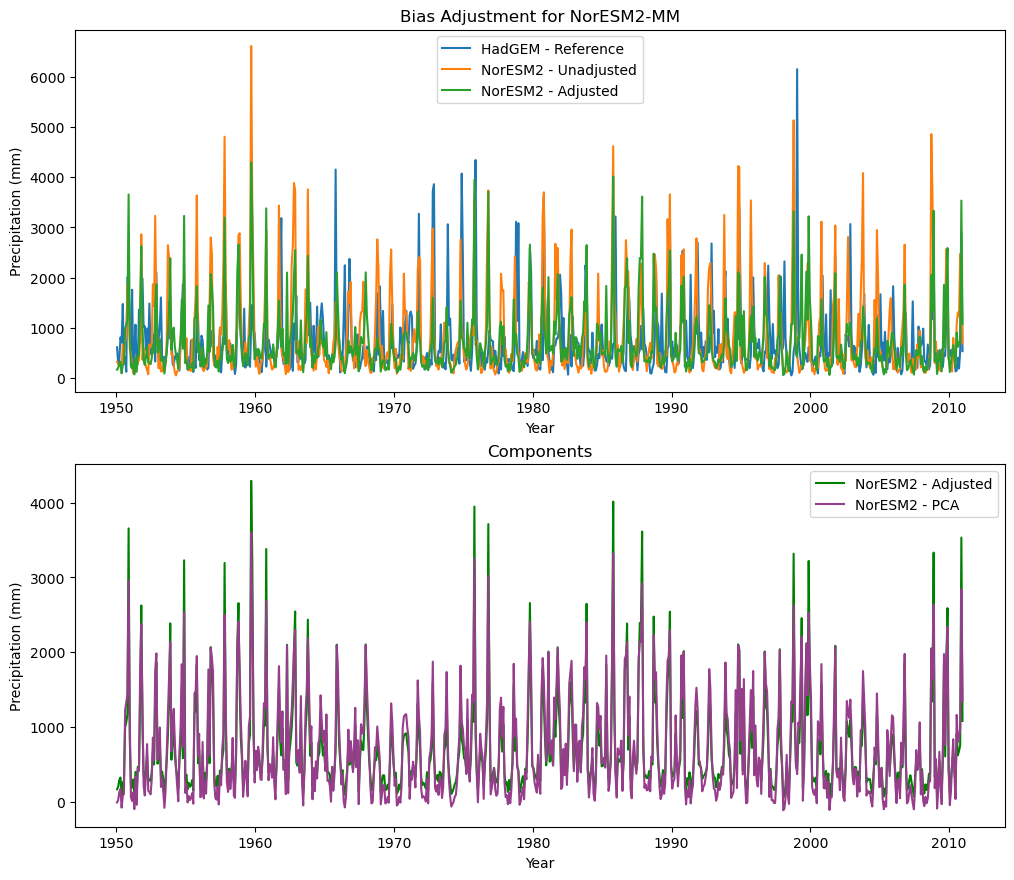

In [22]:
# Code based on xclim's notebook, "Statistical Downscaling and Bias-Adjustment"

# some Analysis figures
fig = plt.figure(figsize=(12, 16))
gs = plt.matplotlib.gridspec.GridSpec(3, 2, fig)


axT = plt.subplot(gs[0, :])
reft.isel(lon=1).plot(ax=axT, label="HadGEM - Reference")
simt.isel(lon=1).plot(ax=axT, label="NorESM2 - Unadjusted")
scen2.isel(lon=1).plot(ax=axT, label="NorESM2 - Adjusted")
axT.set_ylabel("Precipitation (mm)")
axT.set_xlabel("Year")
axT.legend()
axT.set_title("Bias Adjustment for NorESM2-MM")

#PCA and EQM Plots
axT = plt.subplot(gs[1,:])
scen2.isel(lon=1).plot(ax=axT, label="NorESM2 - Adjusted", color='green')
scen1.isel(lon=1).plot(ax=axT, label="NorESM2 - PCA", color='#963e8b')
axT.set_ylabel("Precipitation (mm)")
axT.set_xlabel("Year")
axT.legend()
axT.set_title("Components")

#### Reference for xclim

Bourgault, P., Huard, D., Smith, T. J., Logan, T., Aoun, A., Lavoie, J., Dupuis, É., Rondeau-Genesse, G., Alegre, R., Barnes, C., Laperrière, A. B., Biner, S., Caron, D., Ehbrecht, C., Fyke, J., Keel, T., Labonté, M.-P., Lierhammer, L., Low, J.-F., … Whelan, C. (2023). Xclim: Xarray-based climate data analytics. Journal of Open Source Software, 8(85), 5415. https://doi.org/10.21105/joss.05415 